In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from math import pi
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
# Don't need to f-string loop this, all column headers will remain the same
source = requests.get('https://www.fangraphs.com/leaders.aspx?pos=all&stats=sta&lg=all&qual=y&type=c,4,5,11,7,8,13,-1,36,37,40,43,44,48,51,-1,6,45,62,-1,59,3,21,47,49,60,75,77,79,81,83,85,87,76,41,42&season=2018&month=0&season1=2000&ind=1&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate=').text
soup = BeautifulSoup(source, 'lxml')
cols = []
matches = soup.find_all('th', scope = 'col')
for match in matches:
    match = str(match)
    match = match[match.find(',d">')+len(',d">'):match.find('</a>')]
    cols.append(match)

cols[0] = cols[0][cols[0].rfind('>')+1:cols[0].find('<')]
cols[20] = cols[20][cols[20].rfind('>')+1:]
cols[24] = 'FlyBall%'
cols

['#',
 'Season',
 'Name',
 'Team',
 'W',
 'L',
 'SV',
 'G',
 'GS',
 'IP',
 'K/9',
 'BB/9',
 'HR/9',
 'BABIP',
 'LOB%',
 'GB%',
 'HR/FB',
 'ERA',
 'FIP',
 'xFIP',
 'WAR',
 'Age',
 'HBP',
 'LD%',
 'FlyBall%',
 'Dollars',
 'FB%',
 'SL%',
 'CT%',
 'CB%',
 'CH%',
 'SF%',
 'KN%',
 'FBv',
 'AVG',
 'WHIP']

In [33]:
dfs = []
for n in range(1,20):
    page = requests.get(f'https://www.fangraphs.com/leaders.aspx?pos=all&stats=sta&lg=all&qual=y&type=c,4,5,11,7,8,13,-1,36,37,40,43,44,48,51,-1,6,45,62,-1,59,3,21,47,49,60,75,77,79,81,83,85,87,76,41,42&season=2018&month=0&season1=2000&ind=1&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate=2018-12-31&sort=20,d&page={n}_50').content
    df = pd.read_html(page)
    # Remove the last "next page" row from the dataframe
    players = df[16].iloc[:-1, :]
    players.columns = cols
    dfs.append(players)

In [34]:
combined = pd.DataFrame()
for data in dfs:
    combined = pd.concat([combined, data], sort = False)
    

In [35]:
combined.dropna(subset=['FBv', 'Dollars', 'HR/FB'], inplace = True)

In [20]:
combined.fillna(0, inplace = True)

In [36]:
combined.reset_index(drop = True, inplace = True)

In [37]:
combined.drop(['#'], axis = 1, inplace = True)

In [38]:
# Strip % and $ signs from all columns
for column in combined.columns:
    combined[column] = combined[column].str.strip('%')
    combined[column] = combined[column].str.strip('$')

In [39]:
combined.loc[566,:]

Season              2011
Name        Jaime Garcia
Team           Cardinals
W                     13
L                      7
SV                     0
G                     32
GS                    32
IP                 194.2
K/9                 7.21
BB/9                2.31
HR/9                0.69
BABIP               .318
LOB%               66.8 
GB%                53.6 
HR/FB               8.9 
ERA                 3.56
FIP                 3.23
xFIP                3.31
WAR                  3.2
Age                   24
HBP                    2
LD%                18.4 
FlyBall%           28.0 
Dollars             24.2
FB%                53.1 
SL%                  NaN
CT%                21.1 
CB%                 9.7 
CH%                16.1 
SF%                  NaN
KN%                  NaN
FBv                 89.8
AVG                 .267
WHIP                1.32
Name: 566, dtype: object

In [40]:
for colname in combined.columns[3:]:
    combined[colname] = pd.to_numeric(combined[colname], errors = 'coerce')

In [41]:
combined

,Season,Name,Team,W,L,SV,G,GS,IP,K/9,...,FB%,SL%,CT%,CB%,CH%,SF%,KN%,FBv,AVG,WHIP
0,2004,Randy Johnson,Diamondbacks,16,14,0,35,35,245.2,10.62,...,45.3,43.6,NaN,NaN,6.7,4.5,NaN,93.7,0.195,0.90
1,2002,Curt Schilling,Diamondbacks,23,7,0,35,35,258.1,10.97,...,55.2,12.6,NaN,5.6,4.2,22.4,NaN,92.7,0.221,0.96
2,2018,Jacob deGrom,Mets,10,9,0,32,32,217.0,11.16,...,52.1,23.9,NaN,7.9,16.1,NaN,NaN,96.0,0.194,0.91
3,2011,Roy Halladay,Phillies,19,6,0,32,32,233.2,8.47,...,22.6,NaN,44.8,17.1,NaN,15.5,NaN,92.0,0.233,1.04
4,2009,Zack Greinke,Royals,16,8,0,33,33,229.1,9.50,...,59.4,20.2,NaN,14.3,6.1,NaN,NaN,93.7,0.227,1.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,2018,Kevin Gausman,- - -,10,11,0,31,31,183.2,7.25,...,58.5,14.2,NaN,NaN,5.4,21.9,NaN,93.6,0.263,1.30
852,2009,Nick Blackburn,Twins,11,11,0,33,33,205.2,4.29,...,60.6,NaN,20.7,11.1,7.7,NaN,NaN,90.6,0.286,1.37
853,2012,Ian Kennedy,Diamondbacks,15,12,0,33,33,208.1,8.08,...,65.9,0.7,8.4,7.6,17.4,NaN,NaN,89.7,0.260,1.30
854,2006,Cliff Lee,Indians,14,11,0,33,33,200.2,5.79,...,69.7,2.7,6.3,8.7,12.6,NaN,NaN,89.0,0.275,1.41


In [42]:
combined['IP/G']  = round(combined['IP']//combined['GS'] + (combined['IP']/combined['GS'] - combined['IP']//combined['GS']), 2)
combined['IP/G']

0      7.01
1      7.37
2      6.78
3      7.29
4      6.94
       ... 
851    5.91
852    6.22
853    6.31
854    6.07
855    6.03
Name: IP/G, Length: 856, dtype: float64

In [43]:
combined.dropna(subset=['FBv', 'Dollars', 'HR/FB'], inplace = True)

In [44]:
combined.fillna(0)

,Season,Name,Team,W,L,SV,G,GS,IP,K/9,...,SL%,CT%,CB%,CH%,SF%,KN%,FBv,AVG,WHIP,IP/G
0,2004,Randy Johnson,Diamondbacks,16,14,0,35,35,245.2,10.62,...,43.6,0.0,0.0,6.7,4.5,0.0,93.7,0.195,0.90,7.01
1,2002,Curt Schilling,Diamondbacks,23,7,0,35,35,258.1,10.97,...,12.6,0.0,5.6,4.2,22.4,0.0,92.7,0.221,0.96,7.37
2,2018,Jacob deGrom,Mets,10,9,0,32,32,217.0,11.16,...,23.9,0.0,7.9,16.1,0.0,0.0,96.0,0.194,0.91,6.78
3,2011,Roy Halladay,Phillies,19,6,0,32,32,233.2,8.47,...,0.0,44.8,17.1,0.0,15.5,0.0,92.0,0.233,1.04,7.29
4,2009,Zack Greinke,Royals,16,8,0,33,33,229.1,9.50,...,20.2,0.0,14.3,6.1,0.0,0.0,93.7,0.227,1.07,6.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,2018,Kevin Gausman,- - -,10,11,0,31,31,183.2,7.25,...,14.2,0.0,0.0,5.4,21.9,0.0,93.6,0.263,1.30,5.91
852,2009,Nick Blackburn,Twins,11,11,0,33,33,205.2,4.29,...,0.0,20.7,11.1,7.7,0.0,0.0,90.6,0.286,1.37,6.22
853,2012,Ian Kennedy,Diamondbacks,15,12,0,33,33,208.1,8.08,...,0.7,8.4,7.6,17.4,0.0,0.0,89.7,0.260,1.30,6.31
854,2006,Cliff Lee,Indians,14,11,0,33,33,200.2,5.79,...,2.7,6.3,8.7,12.6,0.0,0.0,89.0,0.275,1.41,6.07


In [8]:
combined.fillna(0, inplace = True)

In [ ]:
combined.dropna(subset=['FBv', 'Dollars', 'HR/FB'], inplace = True)

In [45]:
combined.reset_index(drop = True, inplace = True)

In [ ]:
combined.dropna(subset=['FBv', 'Dollars', 'HR/FB'], inplace = True)

In [46]:
K_ptile = []
BB_ptile = []
IPG_ptile = []
BABIP_ptile = []
FBv_ptile = []
GB_ptile = []
for i in range(len(combined)):
    K_ptile.append(percentileofscore(combined['K/9'], combined.loc[i,'K/9']))
    BB_ptile.append(100 - (percentileofscore(combined['BB/9'], combined.loc[i,'BB/9'])))
    IPG_ptile.append(percentileofscore(combined['IP/G'], combined.loc[i,'IP/G']))
    BABIP_ptile.append(100-(percentileofscore(combined['BABIP'], combined.loc[i,'BABIP'])))
    FBv_ptile.append(percentileofscore(combined['FBv'], combined.loc[i,'FBv']))
    GB_ptile.append(percentileofscore(combined['GB%'], combined.loc[i,'GB%']))
combined['Strikeouts'] = K_ptile
combined['Control'] = BB_ptile
combined['Stamina/Consistency']= IPG_ptile
combined['BA Against'] = BABIP_ptile
combined['Velocity'] = FBv_ptile
combined['Ground Balls'] = GB_ptile

In [44]:
combined.isna().sum()

Season        0
Name          0
Team          0
W             0
L             0
SV            0
G             0
GS            0
IP            0
K/9           0
BB/9          0
HR/9          0
BABIP         0
LOB%          0
GB%           0
HR/FB         0
ERA           0
FIP           0
xFIP          0
WAR           0
Age           0
HBP           0
LD%           0
FlyBall%      0
Dollars       0
FB%           0
SL%          54
CT%         156
CB%          31
CH%           9
SF%         205
KN%         236
FBv           0
AVG           0
WHIP          0
IP/G          0
dtype: int64

In [ ]:
combined.dtypes

In [47]:
combined

,Season,Name,Team,W,L,SV,G,GS,IP,K/9,...,FBv,AVG,WHIP,IP/G,Strikeouts,Control,Stamina/Consistency,BA Against,Velocity,Ground Balls
0,2004,Randy Johnson,Diamondbacks,16,14,0,35,35,245.2,10.62,...,93.7,0.195,0.90,7.01,96.028037,91.296729,93.282710,89.953271,84.521028,35.280374
1,2002,Curt Schilling,Diamondbacks,23,7,0,35,35,258.1,10.97,...,92.7,0.221,0.96,7.37,97.488318,98.364486,99.123832,38.668224,72.313084,28.037383
2,2018,Jacob deGrom,Mets,10,9,0,32,32,217.0,11.16,...,96.0,0.194,0.91,6.78,98.130841,82.476636,84.404206,67.289720,98.773364,60.046729
3,2011,Roy Halladay,Phillies,19,6,0,32,32,233.2,8.47,...,92.0,0.233,1.04,7.29,70.093458,96.144860,98.422897,35.221963,58.528037,83.177570
4,2009,Zack Greinke,Royals,16,8,0,33,33,229.1,9.50,...,93.7,0.227,1.07,6.94,87.792056,77.862150,90.887850,26.518692,84.521028,18.107477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,2018,Kevin Gausman,- - -,10,11,0,31,31,183.2,7.25,...,93.6,0.263,1.30,5.91,41.413551,52.219626,11.682243,33.411215,83.411215,56.308411
852,2009,Nick Blackburn,Twins,11,11,0,33,33,205.2,4.29,...,90.6,0.286,1.37,6.22,1.518692,85.981308,36.915888,30.549065,36.448598,54.322430
853,2012,Ian Kennedy,Diamondbacks,15,12,0,33,33,208.1,8.08,...,89.7,0.260,1.30,6.31,62.441589,55.490654,46.904206,22.079439,25.934579,9.579439
854,2006,Cliff Lee,Indians,14,11,0,33,33,200.2,5.79,...,89.0,0.275,1.41,6.07,15.478972,45.035047,23.189252,38.668224,18.633178,1.693925


In [62]:
kershaw = combined[combined['Name'] == 'Clayton Kershaw']
kershaw.sort_values(by=['Age'], inplace = True)
kershaw.reset_index(drop = True, inplace = True)
kershaw

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Season,Name,Team,W,L,SV,G,GS,IP,K/9,...,FBv,AVG,WHIP,IP/G,Strikeouts,Control,Stamina/Consistency,BA Against,Velocity,Ground Balls
0,2009,Clayton Kershaw,Dodgers,8,8,0,30,30,169.0,9.64,...,93.9,0.197,1.24,5.63,89.310748,0.467290,3.095794,84.696262,86.214953,15.128505
1,2010,Clayton Kershaw,Dodgers,13,10,0,32,32,204.1,9.34,...,92.5,0.211,1.18,6.38,85.397196,8.644860,53.971963,76.927570,67.815421,18.633178
2,2011,Clayton Kershaw,Dodgers,21,5,0,33,33,233.1,9.57,...,93.4,0.204,0.98,7.06,88.843458,73.364486,95.151869,86.098131,81.483645,35.981308
3,2012,Clayton Kershaw,Dodgers,14,9,0,33,33,227.2,9.05,...,93.2,0.204,1.02,6.88,81.950935,50.408879,88.084112,91.004673,79.205607,63.726636
4,2013,Clayton Kershaw,Dodgers,16,9,0,33,33,236.0,8.85,...,92.6,0.192,0.92,7.15,77.920561,78.855140,97.021028,96.203271,69.918224,56.308411
5,2014,Clayton Kershaw,Dodgers,21,3,0,27,27,198.1,10.85,...,93.0,0.194,0.86,7.34,97.079439,94.742991,98.948598,72.605140,76.577103,86.273364
6,2015,Clayton Kershaw,Dodgers,16,7,0,33,33,232.2,11.64,...,93.6,0.193,0.88,7.04,98.831776,90.712617,94.742991,67.289720,83.411215,79.147196
7,2017,Clayton Kershaw,Dodgers,18,4,0,27,27,175.0,10.39,...,92.7,0.210,0.95,6.48,94.450935,93.282710,62.733645,87.733645,72.313084,69.684579


In [63]:
plotdf = kershaw[['Age', 'Strikeouts', 'Control','Stamina/Consistency','Velocity','Ground Balls', 'BA Against']].T
plotdf.rename(columns=plotdf.iloc[0], inplace = True)
plotdf.drop(['Age'], axis = 0, inplace = True)
plotdf = plotdf.append(plotdf.iloc[0,:])
plotdf

,21.0,22.0,23.0,24.0,25.0,26.0,27.0,29.0
Strikeouts,89.310748,85.397196,88.843458,81.950935,77.920561,97.079439,98.831776,94.450935
Control,0.467290,8.644860,73.364486,50.408879,78.855140,94.742991,90.712617,93.282710
Stamina/Consistency,3.095794,53.971963,95.151869,88.084112,97.021028,98.948598,94.742991,62.733645
Velocity,86.214953,67.815421,81.483645,79.205607,69.918224,76.577103,83.411215,72.313084
Ground Balls,15.128505,18.633178,35.981308,63.726636,56.308411,86.273364,79.147196,69.684579
BA Against,84.696262,76.927570,86.098131,91.004673,96.203271,72.605140,67.289720,87.733645
Strikeouts,89.310748,85.397196,88.843458,81.950935,77.920561,97.079439,98.831776,94.450935


In [58]:
plotdf.columns

Float64Index([27.0, 26.0, 23.0, 25.0, 24.0, 22.0, 29.0, 21.0], dtype='float64')

In [7]:
combined.dropna(subset=['FBv', 'Dollars', 'HR/FB'], inplace = True)

In [66]:
for count, i in enumerate(range(4)):
    fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2)
    if count < 2:
        fig.add_trace(go.Scatterpolar(r = plotdf.iloc[:,i], theta = plotdf.index, mode = 'lines', 
                                  line_width = 2, line_color = 'darkblue', opacity = 0.8), row=1, col = count+1)
    else:
        fig.add_trace(go.Scatterpolar(r = plotdf.iloc[:,i], theta = plotdf.index, mode = 'lines', 
                                  line_width = 2, line_color = 'darkblue', opacity = 0.8), row=2, col = count-1)
    fig.update_traces(fill='toself', fillcolor = 'lightblue')
    fig.update_layout(title=dict(text = f'Age: {plotdf.columns[i]}', x = 0.5, y = 0.95),
                      # Remove default circular background
                      polar = dict(#bgcolor = 'rgba(0,0,0,0)',
                                   # Set 'scale' to be at -30 degrees, lines up with a vertex
                                   radialaxis_angle = -30,
                                            radialaxis_tickfont_size = 12,
                                            angularaxis_tickfont_size = 16,
                                            angularaxis = dict(direction = 'clockwise', period = 6, gridcolor = 'black', linecolor = 'rgba(0,0,0,0)'),
                                           radialaxis = dict(showgrid = True, showline = False, showticklabels = True, 
                                                             range = (0,100), layer = "above traces")),
                     paper_bgcolor = 'lightgrey')
    fig.show()

In [ ]:
combined.sort_values(by=['WAR'], ascending=False, inplace=True)

In [78]:
plotdf1 = combined[['Name', 'Strikeouts','Velocity', 'Control','Stamina/Consistency', 'BA Against', 'Ground Balls', 'WAR', 'Age']]
#plotdf1.sort_values(by=['Age'], inplace = True)
plotdf1.reset_index(drop=True, inplace=True)
plotdf1

,Name,Strikeouts,Velocity,Control,Stamina/Consistency,BA Against,Ground Balls,WAR,Age
0,Randy Johnson,96.028037,84.521028,91.296729,93.282710,89.953271,35.280374,9.6,40
1,Curt Schilling,97.488318,72.313084,98.364486,99.123832,38.668224,28.037383,9.4,35
2,Jacob deGrom,98.130841,98.773364,82.476636,84.404206,67.289720,60.046729,9.0,30
3,Roy Halladay,70.093458,58.528037,96.144860,98.422897,35.221963,83.177570,8.7,34
4,Zack Greinke,87.792056,84.521028,77.862150,90.887850,26.518692,18.107477,8.7,25
...,...,...,...,...,...,...,...,...,...
851,Kevin Gausman,41.413551,83.411215,52.219626,11.682243,33.411215,56.308411,2.4,27
852,Nick Blackburn,1.518692,36.448598,85.981308,36.915888,30.549065,54.322430,2.4,27
853,Ian Kennedy,62.441589,25.934579,55.490654,46.904206,22.079439,9.579439,2.4,27
854,Cliff Lee,15.478972,18.633178,45.035047,23.189252,38.668224,1.693925,2.3,27


In [85]:
plotdf1.iloc[0,0]

96.02803738317758

In [69]:
def radar(num_vars, frame = 'circle'):
    '''
    num_vars = # of variables
    frame = shape of frame (default = circle)
    '''
    
    # create evenly spaced vertices starting at 0, ending at 2*pi (360deg) for 'num_vars' times
    theta = np.linspace(0, 2*np.pi, num = num_vars, endpoint = False)
    
    class RadarAxes(PolarAxes):
        
        name = 'radar'
        # variable # of args
        # kwags for variable keyworded argument list
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # set first axis @ 90 degrees (ie. at top)
            self.set_theta_zero_location('N')
        
        def fill(self, *args, closed = True, **kwargs):
            # make line closed by default
            return super().fill(closed = closed, *args, **kwargs)
        
        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)
                
        # add labels at their corresponding degrees        
        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        # how to create frame
        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)
        
        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)
            
        
        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)
    register_projection(RadarAxes)
    return theta

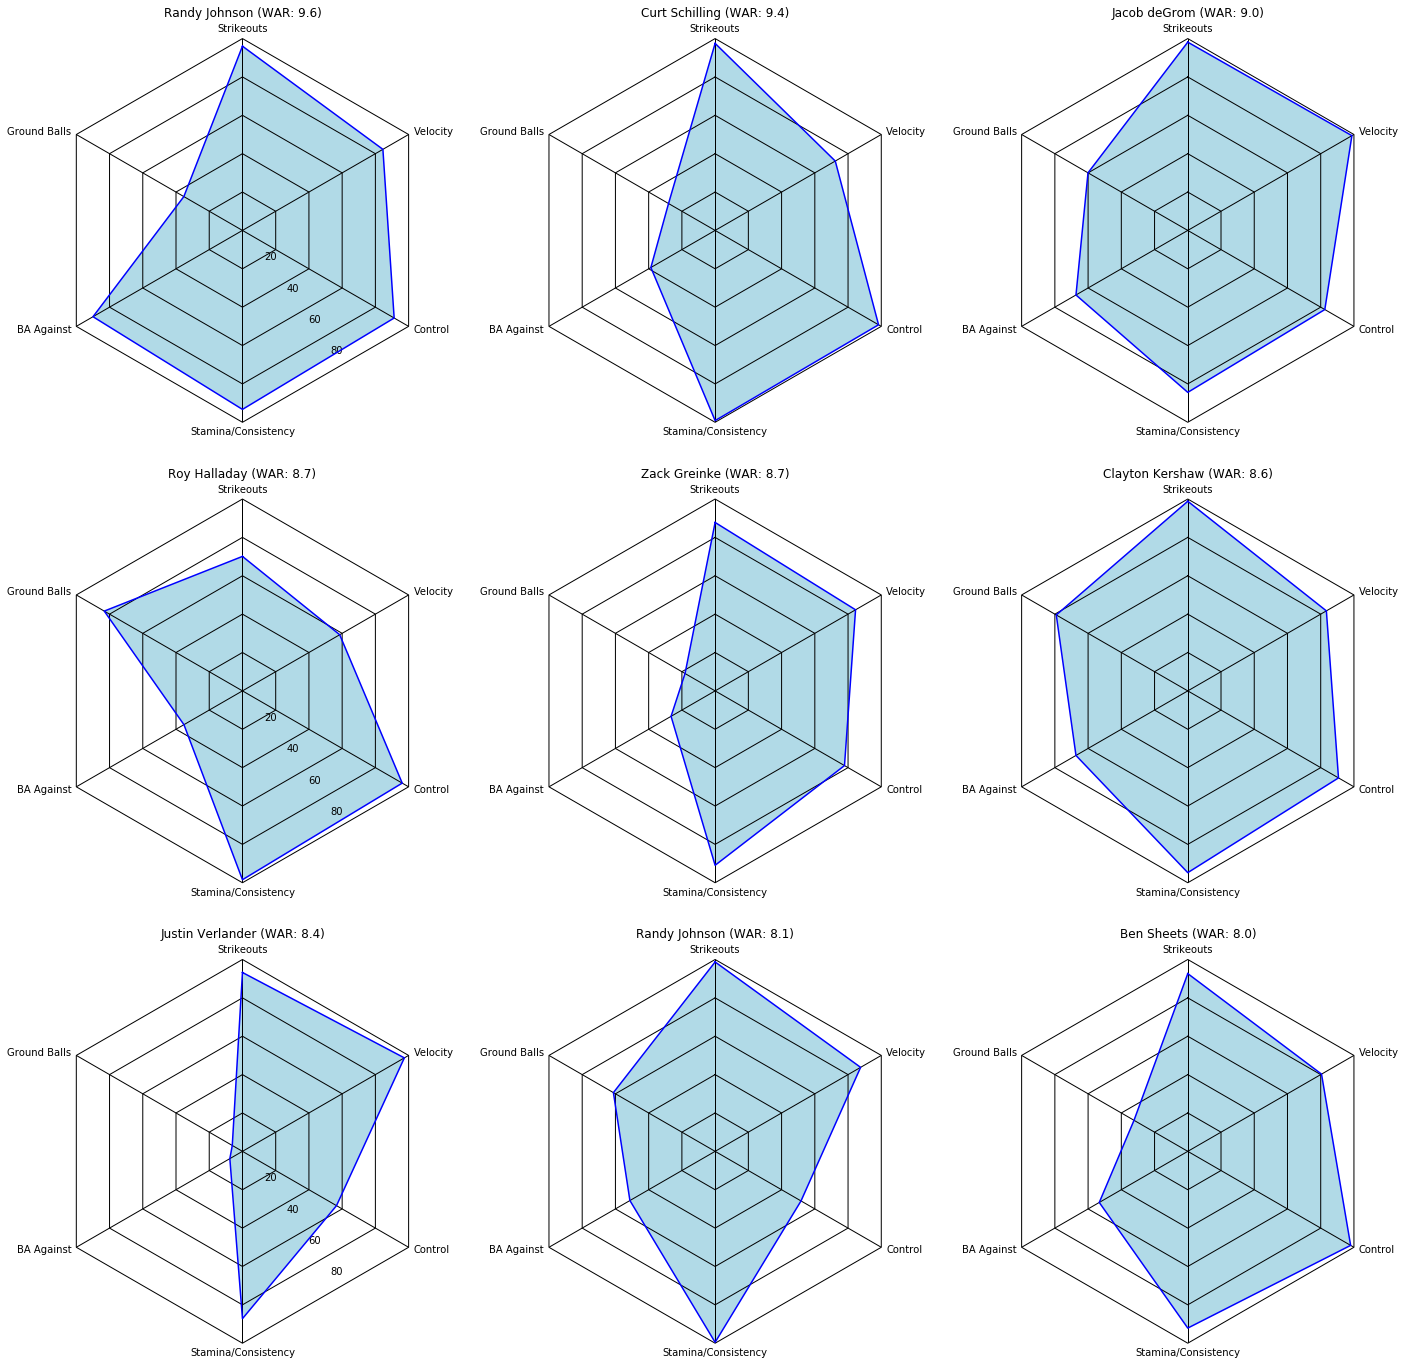

In [86]:
N = 6

x_as = [n / float(N) * 2 * pi for n in range(N)]

theta = radar(6, frame = 'polygon')
theta

# Set color of axes
plt.rc('axes', linewidth=1, edgecolor="black", facecolor = "white")



# Create polar plot
fig, ax = plt.subplots(3, 3, figsize=(24,24), sharex = True, sharey= True, subplot_kw = dict(projection='radar'))
ax = ax.flat
plt.setp(ax, yticks = [20, 40, 60, 80], yticklabels = ["20", "40", "60", "80"])

# Set canvas colour
#fig.patch.set_facecolor('xkcd:mint green')

for j in range(9):
    # Set data
    x = np.array(plotdf1.columns[1:-2].values)
    y = np.array(pd.to_numeric(plotdf1.iloc[j,1:-2].values))
    # Set clockwise rotation. That is:
    ax[j].set_theta_offset(pi / 2)
    ax[j].set_theta_direction(-1)


    # Set position of y-labels
    ax[j].set_rlabel_position(145)


    # Set color and linestyle of grid
    ax[j].xaxis.grid(True, color="black", linestyle='solid', linewidth=1)
    ax[j].yaxis.grid(True, color="black", linestyle='solid', linewidth=1)


    # Set number of radial axes and remove labels
    plt.xticks(x_as[:], [])

    # Set radial ticks
#     ax[j].set_rticks([0, 20, 40, 60, 80, 100])
    #ax[j].set_rlabel_position(145)


    # Plot data
    ax[j].plot(x_as, y, linewidth=1.5, color = 'b', linestyle='solid', zorder=3)

    # Fill area
    ax[j].fill(x_as, y, 'lightblue', alpha=0.95)


    # Set axes limits
    plt.ylim(0, 100)
#   plt.yticks([0, 20, 40, 60, 80, 100], ["0", "20", "40", "60", "80", "100"])
    
    # Add title
    ax[j].set_title(f'{plotdf1.loc[j, "Name"]} (WAR: {plotdf1.loc[j, "WAR"]})', position=(0.5, 1.05), horizontalalignment='center', verticalalignment='center')
    
    # Adjust positioning of vertex labels based on their position from 0 - 2pi (circle)
    for i in range(N):
        # Calculate angles of the 6 vertices
        angle_rad = i / float(N) * 2 * pi
        # At top center
        if angle_rad == 0:
            ha, distance_ax = "center", 5
        # On right side
        elif 0 < angle_rad < pi:
            ha, distance_ax = "left", 3
        # On bottom
        elif angle_rad == pi:
            ha, distance_ax = "center", 5
        # On left side
        else:
            ha, distance_ax = "right", 3
        # Insert the text @ the angle position
        ax[j].text(angle_rad, 100 + distance_ax, x[i], size=10, horizontalalignment=ha, verticalalignment="center")
    

# Show polar plot
plt.show()

In [ ]:
np.array(plotdf.loc[plotdf['Age'] == plotdf['Age'].min()].iloc[:,1:-2])

In [ ]:
plotdf = jays[['Name', 'K_ptile', 'BB_ptile','IPG_ptile','FBv_ptile','GB_ptile', 'BABIP_ptile']]
plotdf

In [107]:
plotdf.columns[1:-2].values

array(['Strikeouts', 'Velocity', 'Control', 'Stamina/Consistency',
       'BA Against', 'Ground Balls'], dtype=object)

In [112]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [85]:
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider, Button, RadioButtons

In [98]:
plotdf.loc[plotdf['Age'] == 21].iloc[:,1:-2]

,Strikeouts,Velocity,Control,Stamina/Consistency,BA Against,Ground Balls
0,79.621849,80.252101,0.420168,1.680672,62.815126,13.865546


In [119]:
%matplotlib notebook

N = 6

x_as = [n / float(N) * 2 * pi for n in range(N)]

theta = radar(6, frame = 'polygon')
theta

def plot_func(age):
    # Set color of axes (ie area within plot)
    plt.rc('axes', linewidth=1, edgecolor="black", facecolor = "white")



    # Create polar plot
    fig, ax = plt.subplots(figsize=(6,6), sharex = True, sharey= True, subplot_kw = dict(projection='radar'))
    #ax = ax.flat
    plt.setp(ax, yticks = [20, 40, 60, 80], yticklabels = ["20", "40", "60", "80"])

    # Set canvas colour
    #fig.patch.set_facecolor('xkcd:mint green')


    x = np.array(plotdf.columns[1:-2].values)
    y = np.array(plotdf.loc[plotdf['Age'] == age].iloc[:,1:-2]).reshape(6,1)
    # Set clockwise rotation. That is:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)


    # Set position of y-labels
    ax.set_rlabel_position(145)


    # Set color and linestyle of grid
    ax.xaxis.grid(True, color="black", linestyle='solid', linewidth=1)
    ax.yaxis.grid(True, color="black", linestyle='solid', linewidth=1)


    # Set number of radial axes and remove labels
    plt.xticks(x_as[:], [])

    # Set radial ticks
    #     ax[j].set_rticks([0, 20, 40, 60, 80, 100])
    #ax[j].set_rlabel_position(145)


    # Plot data
    line = ax.plot(x_as, y, linewidth=1.5, color = 'b', linestyle='solid', zorder=3)
    line

    # Fill area
    ax.fill(x_as, y, 'lightblue', alpha=0.95)


    # Set axes limits
    plt.ylim(0, 100)
    #   plt.yticks([0, 20, 40, 60, 80, 100], ["0", "20", "40", "60", "80", "100"])

    # Add title
    ax.set_title(f'{plotdf.loc[0, "Name"]} Age: {age}', position=(0.5, 1.05), horizontalalignment='center', verticalalignment='center')

    # Adjust positioning of vertex labels based on their position from 0 - 2pi (circle)
    for i in range(N):
        # Calculate angles of the 6 vertices
        angle_rad = i / float(N) * 2 * pi
        # At top center
        if angle_rad == 0:
            ha, distance_ax = "center", 5
        # On right side
        elif 0 < angle_rad < pi:
            ha, distance_ax = "left", 3
        # On bottom
        elif angle_rad == pi:
            ha, distance_ax = "center", 5
        # On left side
        else:
            ha, distance_ax = "right", 3
        # Insert the text @ the angle position
        ax.text(angle_rad, 100 + distance_ax, x[i], size=10, horizontalalignment=ha, verticalalignment="center")

interact(plot_func, age = widgets.FloatSlider(value=plotdf['Age'].min(),
                                               min=plotdf['Age'].min(),
                                               max=plotdf['Age'].max(),
                                               step=1))


                 

# Show polar plot
plt.show()

interactive(children=(FloatSlider(value=21.0, description='age', max=29.0, min=21.0, step=1.0), Output()), _do…

In [126]:

from bokeh import matplotlib

ImportError: cannot import name 'matplotlib' from 'bokeh' (C:\ProgramData\Anaconda\lib\site-packages\bokeh\__init__.py)

In [120]:
import bokeh

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\ProgramData\Anaconda\lib\site-packages\matplotlib\animation.py", line 953, in _start
    self._init_draw()
  File "C:\ProgramData\Anaconda\lib\site-packages\matplotlib\animation.py", line 1735, in _init_draw
    self._drawn_artists = self._init_func()
  File "<ipython-input-82-e28c17ad059a>", line 19, in init
    line.set_data([], [])
NameError: name 'line' is not defined


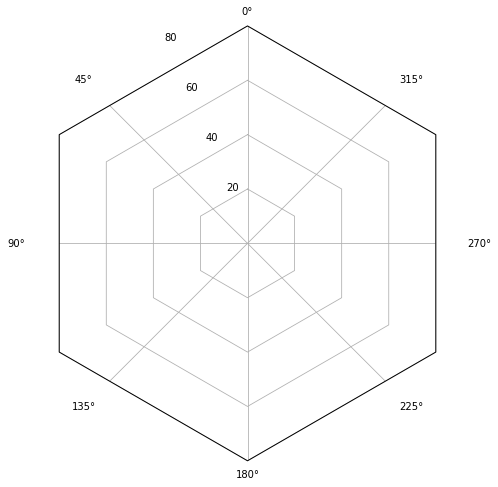

In [83]:
N = 6

x_as = [n / float(N) * 2 * pi for n in range(N)]

theta = radar(6, frame = 'polygon')
theta

# Set color of axes (ie area within plot)
plt.rc('axes', linewidth=1, edgecolor="black", facecolor = "white")



# Create polar plot
fig, ax = plt.subplots(figsize=(8,8), sharex = True, sharey= True, subplot_kw = dict(projection='radar'))
plt.setp(ax, yticks = [20, 40, 60, 80], yticklabels = ["20", "40", "60", "80"])

# def init(): 
# # creating an empty plot/frame 
#     line.set_data([], []) 
#     return line, 

def animate(i):
    x = np.array(plotdf.columns[1:-2].values)
    for j in range(8):    
        y = np.array(pd.to_numeric(plotdf.iloc[j,1:-2].values))
        ax.plot(x_as, y, linewidth=1.5, color = 'b', linestyle='solid', zorder=3)

    # Set clockwise rotation. That is:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)


    # Set position of y-labels
    ax.set_rlabel_position(145)


    # Set color and linestyle of grid
    ax.xaxis.grid(True, color="black", linestyle='solid', linewidth=1)
    ax.yaxis.grid(True, color="black", linestyle='solid', linewidth=1)


    # Set number of radial axes and remove labels
    plt.xticks(x_as[:], [])

    # Set radial ticks
    #     ax[j].set_rticks([0, 20, 40, 60, 80, 100])
    #ax[j].set_rlabel_position(145)


    # Plot data

    # Fill area
    ax.fill(x_as, y, 'lightblue', alpha=0.95)


    # Set axes limits
    plt.ylim(0, 100)
    #   plt.yticks([0, 20, 40, 60, 80, 100], ["0", "20", "40", "60", "80", "100"])

    # Add title
    ax.set_title(f'{plotdf.loc[j, "Name"]} (WAR: {plotdf.loc[j, "WAR"]}) Age:{plotdf.loc[j,"Age"]}', position=(0.5, 1.05), horizontalalignment='center', verticalalignment='center')

    # Adjust positioning of vertex labels based on their position from 0 - 2pi (circle)
    for i in range(N):
        # Calculate angles of the 6 vertices
        angle_rad = i / float(N) * 2 * pi
        # At top center
        if angle_rad == 0:
            ha, distance_ax = "center", 5
        # On right side
        elif 0 < angle_rad < pi:
            ha, distance_ax = "left", 3
        # On bottom
        elif angle_rad == pi:
            ha, distance_ax = "center", 5
        # On left side
        else:
            ha, distance_ax = "right", 3
        # Insert the text @ the angle position
        ax.text(angle_rad, 100 + distance_ax, x[i], size=10, horizontalalignment=ha, verticalalignment="center")
    
anim = FuncAnimation(fig, animate, init_func=init, frames=200, interval=20, blit=True)
# Show polar plot
#plt.show()

TypeError: cannot unpack non-iterable NoneType object

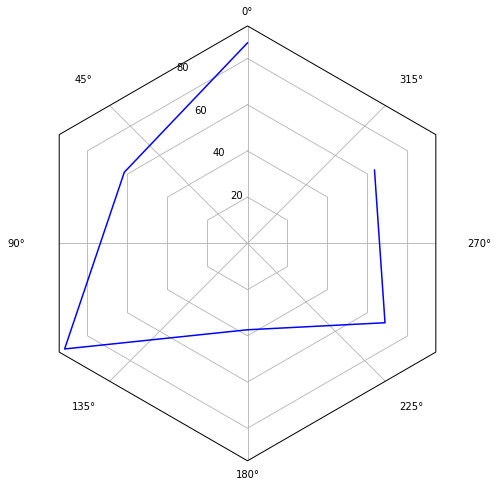

In [84]:
N = 6

x_as = [n / float(N) * 2 * pi for n in range(N)]

theta = radar(6, frame = 'polygon')
theta

# Set color of axes (ie area within plot)
plt.rc('axes', linewidth=1, edgecolor="black", facecolor = "white")
x_data = []
y_data = []
fig, ax = plt.subplots(figsize=(8,8), sharex = True, sharey= True, subplot_kw = dict(projection='radar'))
line, = ax.plot(x_as, y, linewidth=1.5, color = 'b', linestyle='solid', zorder=3)

In [17]:
for i in range(10):
    print(percentileofscore(combined['K/9'], combined.loc[i,'K/9']))

42.857142857142854
94.53781512605042


KeyError: 2

In [36]:
percentileofscore(combined['K/9'], combined.loc[0,'K/9'])

42.857142857142854

In [ ]:
combined.dropna(subset=['FBv', 'Dollars', 'HR/FB'], inplace = True)